# PSFs with LUVOIR A telescope

In this notebook, I will demonstrate how to generate a PSF with the LUVOIR A simulator and how to adjust the wavefront (phase) in its pupil plane.

In [1]:
# Imports
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import hcipy as hc

os.chdir('../../pastis/')
from config import CONFIG_INI
#local is in git_ignore
# config_local overrides global
from e2e_simulators.luvoir_imaging import LuvoirAPLC

In [2]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from csbdeep.utils import normalize

Using TensorFlow backend.


## Get simple PSF

First we will just instantiate the simulator class and get a simple PSF, both with and without the coronagraph in. We will be working with the "small" apodizer design, to keep things simple, so I would suggest to not change that.

### Instantiate LUVOIR simulator class

In [3]:
# Parameters
apodizer = 'small'    # coronagraph specification - don't change
sampling = 4          # PSF sampling - 2 would be Nyquist-Shannon

In [4]:
luvoir = LuvoirAPLC(CONFIG_INI.get('LUVOIR', 'optics_path'), apodizer, sampling)

#### Pupil image

We can display the pupil image easily with `luvoir.aper` and we can plot it. Note how we use a plotting function from `hcipy` instead of `matplotlib`, simply because that's the package we used to develop the simulator.

Text(0.5, 1.0, 'LUVOIR A pupil image')

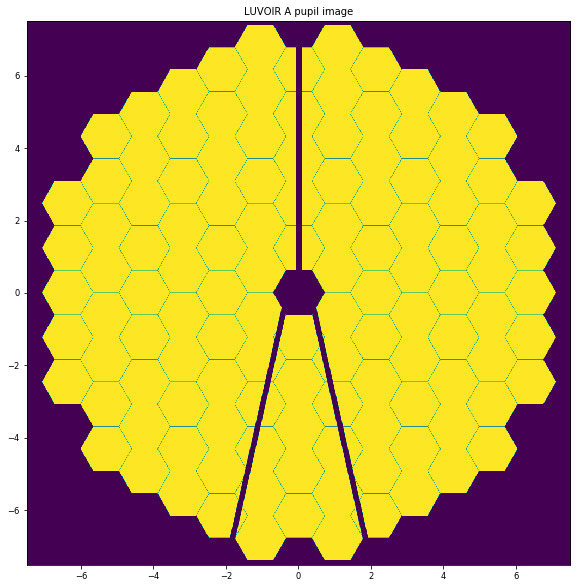

In [5]:
plt.figure(figsize=(10, 10))
hc.imshow_field(luvoir.aper)
plt.title('LUVOIR A pupil image')

LUVOIR A has 120 individual hexagonal segments that can each be controlled individually in piston, tip and tilt. The segments are numbered and we can display each segment numer as shown below. This is a slightly hacky way to do it since I didn't write a method for this class to do this yet, but it does the job for now.

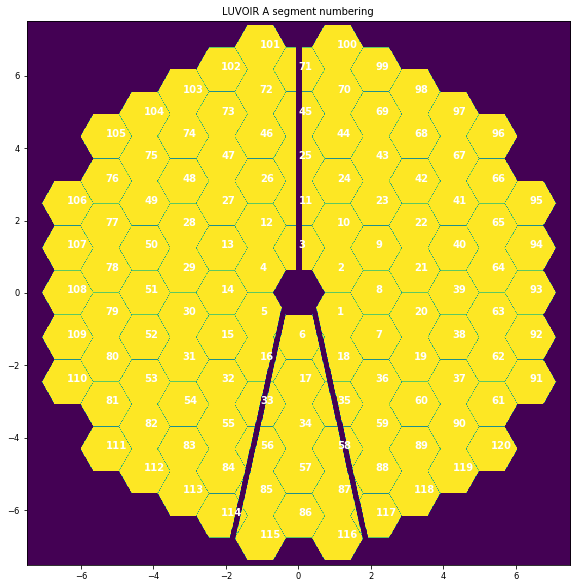

In [6]:
plt.figure(figsize=(10, 10))
hc.imshow_field(luvoir.aper)
plt.title('LUVOIR A segment numbering')
for i, par in enumerate(luvoir.sm.seg_pos):
    pos = par * luvoir.diam
    plt.annotate(s=i+1, xy=pos, xytext=pos, color='white', fontweight='bold')

In order to calculate a perfect PSF *without* the coronagraph in, we need to call `calc_psf()`. The **non-coronagraphic** PSF will be the reference `ref` image that the simulator spits out. The **coronagraphic** image will be called `coro`.

By setting the keyword `display_intermediate=True`, we will get a display of each intermediate optical plane that is of interest to us if we want to have a look at the differen coronagraphic planes. Since we don't really need this though, I will just keep it at its default `False`, so that the PSF compuation happens faster. We do have to set `ref=True` though, otherwise the method only returns a coronagraphic PSF.

In [7]:
# creating PSF, reference= ideal PSF
coro, ref = luvoir.calc_psf(ref=True)

#### Reference PSF

Let's display the reference PSF and check it out. Note how I use `norm=LogNorm()` in order to display the image on a log scale.

**NOTE:** 
I will use the terms "*reference PSF*", "*direct PSF*", "*plain PSF*" and "*non-coronagraphic PSF*" interchangeably.

Text(0.5, 1.0, 'LUVOIR A plain PSF')

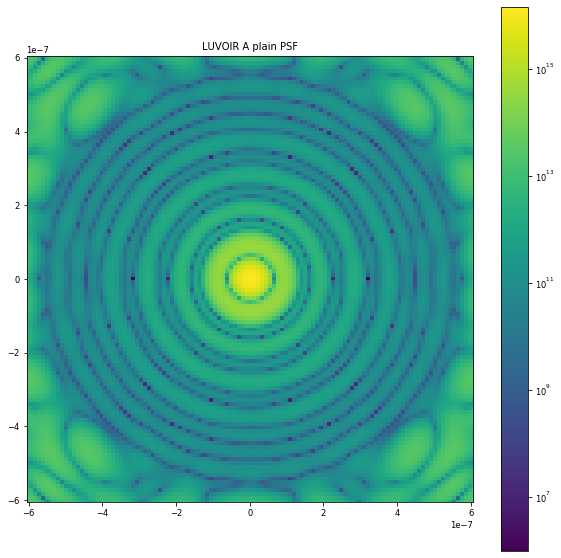

In [8]:
plt.figure(figsize=(10, 10))
hc.imshow_field(ref, norm=LogNorm())
plt.colorbar()
plt.title('LUVOIR A plain PSF')

What's a bit tricky is that these images are not actually arrays, but they are of the custom type `Field`, which is an `hcipy` thing. It's easy though: a `Field` is just a raveled array. And the `Field` actually has an internal method that lets you cast it into a *shaped* Field, which then behaves exactly like a normal numpy array.

In [9]:
# Inspect original reference PSF as a hcipy.Field
print('Type of reference PSF: {}'.format(type(ref)))
print('Shape of reference PSF as Field: {}'.format(ref.shape))

# Cast into normal numpy array
ref_array = ref.shaped
print('\nType of reference PSF as array: {}'.format(type(ref_array)))
print('Shape of reference PSF as array: {}'.format(ref_array.shape))

Type of reference PSF: <class 'hcipy.field.field.Field'>
Shape of reference PSF as Field: (13225,)

Type of reference PSF as array: <class 'hcipy.field.field.Field'>
Shape of reference PSF as array: (115, 115)


And displaying the shaped Field now works normally with `matplotlib` as we know it:

Text(0.5, 1.0, 'Ref PSF as shaped Field = array')

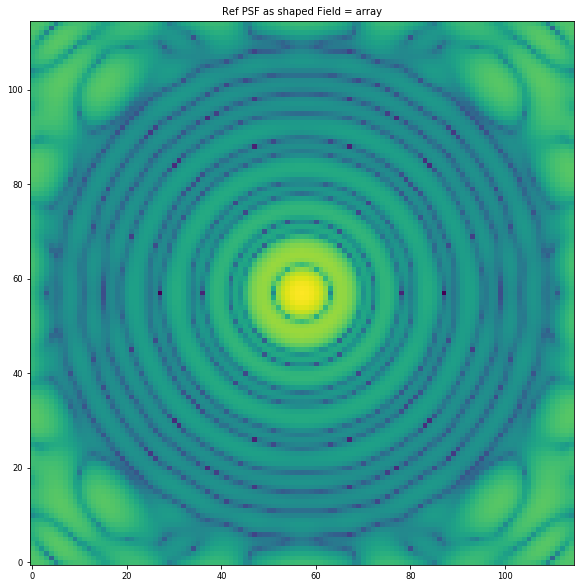

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(ref_array, norm=LogNorm())
plt.title('Ref PSF as shaped Field = array')

#### Coronagraphic PSF

We can do the same thing with the coronagraphic PSF and display it as an array with `matplotlib`.

Shape of coro PSF as array: (115, 115)


Text(0.5, 1.0, 'Coronagraphic PSF, unaberrated and NON-NORMALIZED!!')

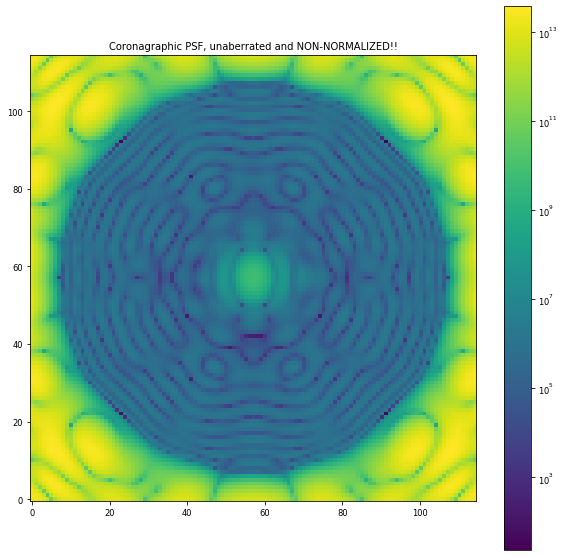

In [11]:
coro_array = coro.shaped
print('Shape of coro PSF as array: {}'.format(coro_array.shape))

plt.figure(figsize=(10, 10))
plt.imshow(coro_array, norm=LogNorm())
plt.colorbar()
plt.title('Coronagraphic PSF, unaberrated and NON-NORMALIZED!!')

The last important thing is that we need to normalize our PSFs to the **peak intensity of the reference PSF**. For this I will define my normalization factor `norm`, which will just be the peak value of the reference PSF. And then anytime I use the coro PSF, I just have to divide it by `norm`. If I now show a colorbar, I can directly read of the contrast in the dark hole.

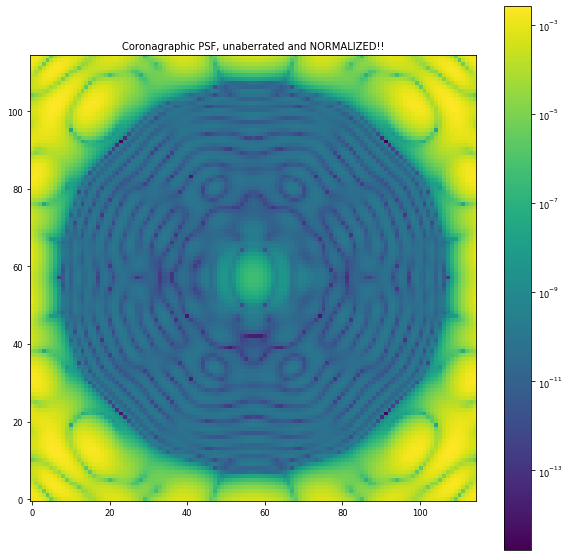

In [12]:
# Define normalization factor as max of ref PSF
norm = np.max(ref)

# Display normalized coro PSF
plt.figure(figsize=(10, 10))
plt.imshow(coro_array/norm, norm=LogNorm())
plt.title('Coronagraphic PSF, unaberrated and NORMALIZED!!')
plt.colorbar()

From this point onwards you can just chose whic PSF you want to use, the reference PSF or the *normalized* coronagraphic PSF.

## Introduce wavefront errors

Let's move on to introducing wavefront errors into our pupil, which will change the intensity distribution in the dark hole (DH). This will also allow us to itroduce a defocus diversity.

#### Defocus

First, we need to identify what Zernike to use. Let's take defocus, which has Noll index 4. We can get its Zernike index with the function `hcipy.mode_basis.noll_to_zernike`.

In [13]:
# Defocus has Noll index 4
noll_index = 4

n_def, m_def = hc.mode_basis.noll_to_zernike(noll_index)
print('Defocus: n={}, m={}'.format(n_def, m_def))

Defocus: n=2, m=0


We can now create this Zernike mode as a Field, like above. We will keep it in the raveled format though, so that we can apply it to the pupil of the telescope.

In [14]:
defocus_mode = hc.mode_basis.zernike(n_def, m_def, D=luvoir.diam, grid=luvoir.aperture.grid)

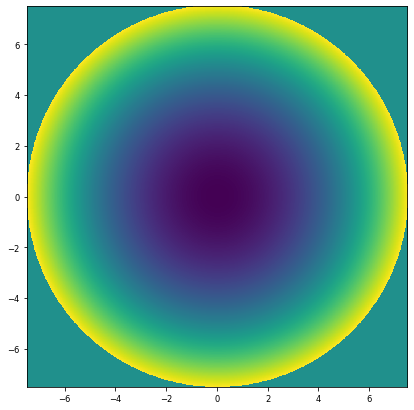

In [15]:
# Let's display the Zernike
plt.figure(figsize=(7, 7))
hc.imshow_field(defocus_mode)

This seems to work fine. Now, obviously this is not perfect since this Zernike is made on a circle, while our telescope actually has its funky segmented shape. This should be fine for now though, but just to make sure that they at least have the same size, let's overlay them.

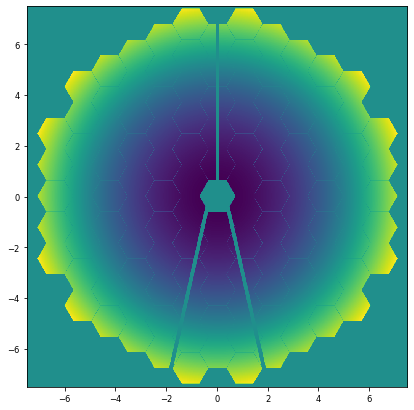

In [16]:
# Overlap the Zernike with the pupil to make sure array sizes match
pup_zern_test = defocus_mode * luvoir.aperture

plt.figure(figsize=(7, 7))
hc.imshow_field(pup_zern_test)

Looks good enough if you ask me. We now have to actually use the Zernike as a phase input in our propagation. To do this, we can use the method `apply_global_zernike()`. We also have to define **how much** of the Zernike we want to apply to the pupil. This Zernike coefficient `a_4`cis in radians.

In [17]:
a_4 = 0.5  # rad
luvoir.apply_global_zernike(a_4 * defocus_mode)

Now we can go ahead and calcualte a new pair of ref and coro PSFs. This time though I will set `display_intermediates=True`, so that I can check what is going on in the pupil plane.

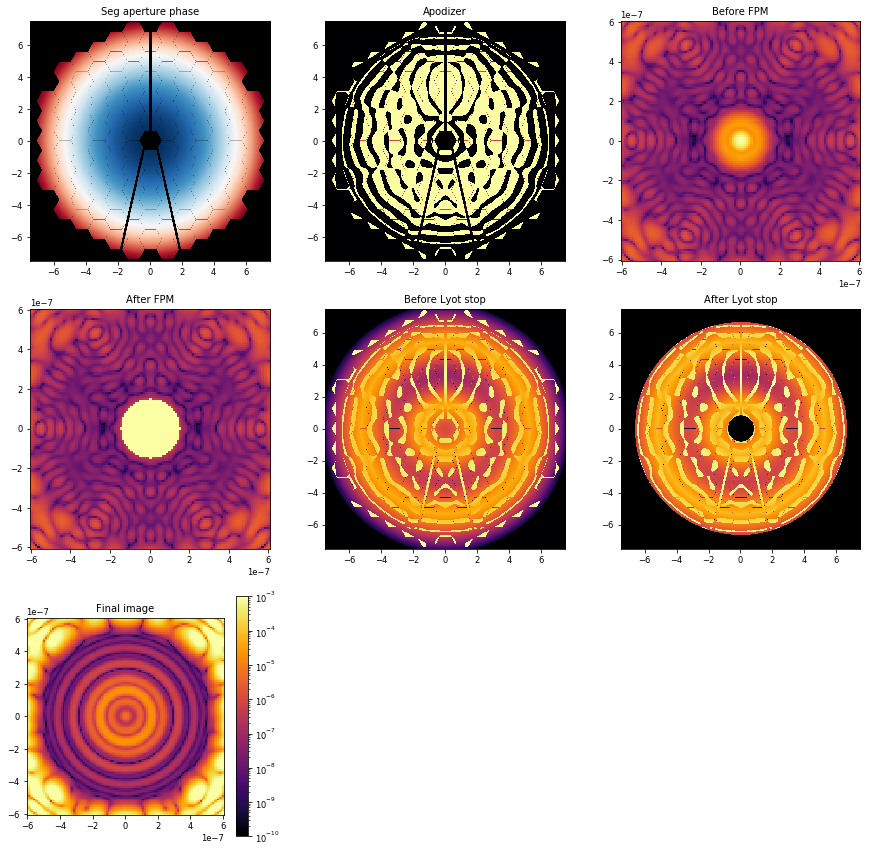

In [18]:
coro_def, ref_def = luvoir.calc_psf(ref=True, display_intermediate=True)

The two plots of interest here are the very first one, which shows the **phase in the pupil** and the very last one, which shows the **intensity distribution** in the final **coronagraphic image**. How about we just put the pupil phase, the ref PSF and the (normalized!) ref PSF next to each other? For this I will have to use another keyword which will actually return all electric fields in all the planes shown above, and I can then pick to display just the **phase** in the **pupil**, next to the two PSFs.

In [19]:
# Recalculate PSFs with applied Zernike, this time also returning intermediate planes,
# but not displaying them by default
coro_def, ref_def, inter = luvoir.calc_psf(ref=True, return_intermediate='intensity')

I keep forgetting how I pack these intermediate plane returns, so let's check that real quick...

In [20]:
print(inter.keys())

dict_keys(['seg_mirror', 'apod', 'before_fpm', 'after_fpm', 'before_lyot', 'after_lyot'])


In [21]:
type(inter['seg_mirror'])   # this is the phase of the segmented mirror, which is the pupil

hcipy.field.field.Field

Ok got it. Now let's display the pupil phase, the ref image and the coro image next to each other. We will keep using the normalization factor `norm` of the **unaberrated** reference image from further above!

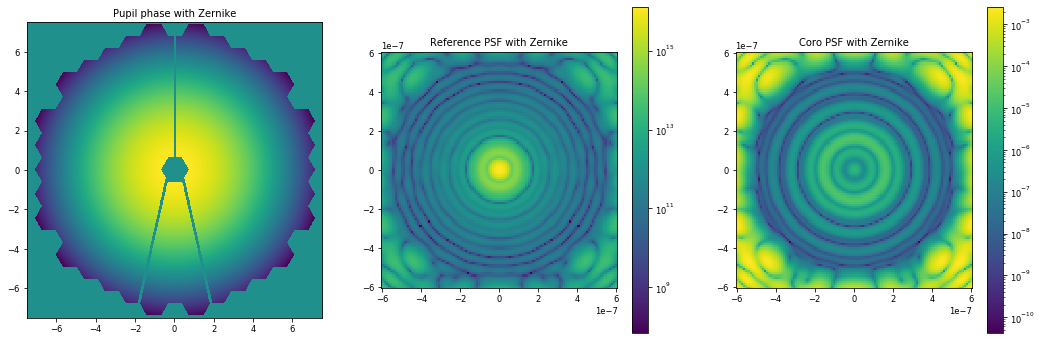

In [22]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
hc.imshow_field(inter['seg_mirror'])
plt.title('Pupil phase with Zernike')

plt.subplot(1, 3, 2)
hc.imshow_field(ref_def, norm=LogNorm())
plt.title('Reference PSF with Zernike')
plt.colorbar()

plt.subplot(1, 3, 3)
hc.imshow_field(coro_def/norm, norm=LogNorm())
plt.title('Coro PSF with Zernike')
plt.colorbar()   # this is always interesting with a coro PSF

Let's also display the unaberrated ref PSF next to the defocused ref PSF.

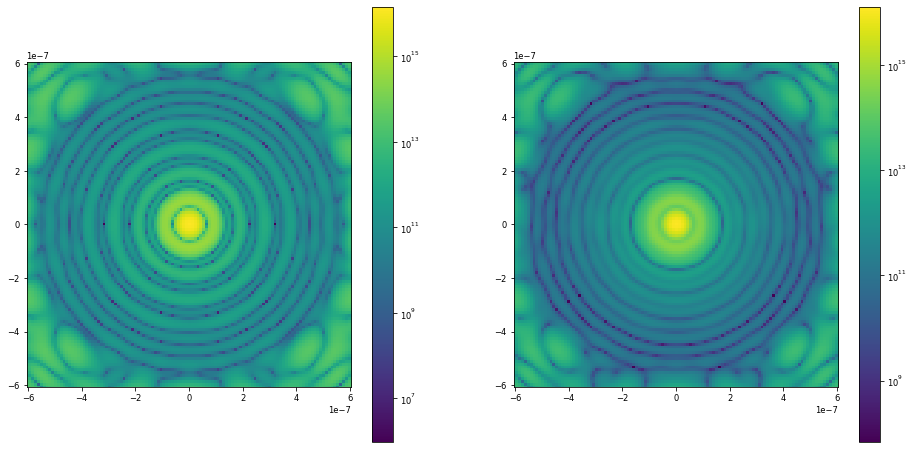

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
hc.imshow_field(ref, norm=LogNorm())
plt.colorbar()

plt.subplot(1, 2, 2)
hc.imshow_field(ref_def, norm=LogNorm())
plt.colorbar()

If the `a_4` is small, the difference will be unnoticable to the eye - the colorbars never lie though! There will always be a higher light level in the DH if there was some defocus introduced.

#### Any Zernike

Let's do this again, but with a different Zernike and a little faster this time. Btw every time you call `apply_global_zernike()`, the pupil phase gets reset to zero, so there is no accidental addition of wavefronts.

In [24]:
# Pick Noll index
noll_index = 5

n_def, m_def = hc.mode_basis.noll_to_zernike(noll_index)
print('Noll {}: n={}, m={}'.format(noll_index, n_def, m_def))

Noll 5: n=2, m=-2


Text(0.5, 1.0, 'Random Zernike')

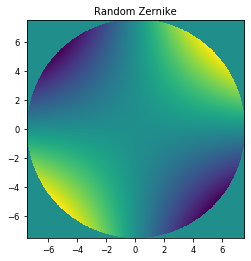

In [25]:
# Create the Zernike
zernike_mode = hc.mode_basis.zernike(n_def, m_def, D=luvoir.diam, grid=luvoir.aperture.grid)

hc.imshow_field(zernike_mode)
plt.title('Random Zernike')

In [26]:
# Decide how much of it you want
a_zern = 0.23   # rad

# Apply to telescope
luvoir.apply_global_zernike(a_zern * zernike_mode)

# Calculate the PSFs and intermediate planes
coro_zern, ref_zern, inter_zern = luvoir.calc_psf(ref=True, return_intermediate='intensity')

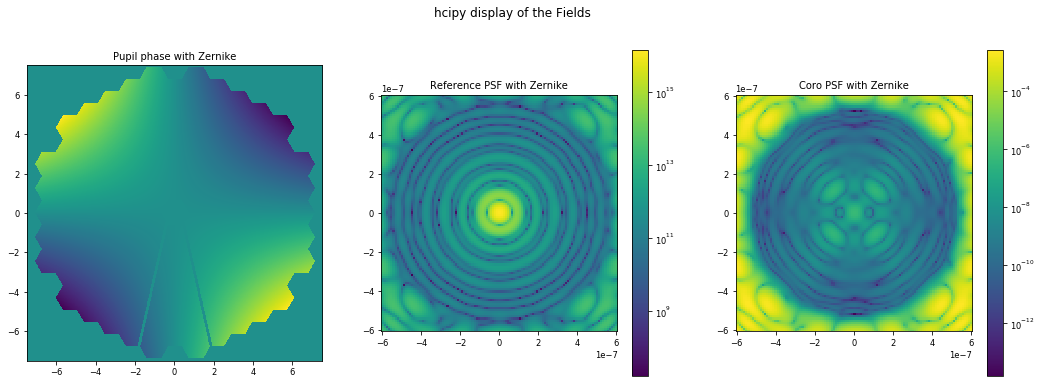

In [27]:
# Display them next to each other
plt.figure(figsize=(18, 6))
plt.suptitle('hcipy display of the Fields')

plt.subplot(1, 3, 1)
hc.imshow_field(inter_zern['seg_mirror'])
plt.title('Pupil phase with Zernike')

plt.subplot(1, 3, 2)
hc.imshow_field(ref_zern, norm=LogNorm())
plt.title('Reference PSF with Zernike')
plt.colorbar()

plt.subplot(1, 3, 3)
hc.imshow_field(coro_zern/norm, norm=LogNorm())
plt.title('Coro PSF with Zernike')
plt.colorbar()   # this is always interesting with a coro PSF

Currently, if the aberration is too big, there can be some funny artifacts show up in the pupil phase image, but I don't know yet if that is a problem or not. And as (I think) I have mentioned before, the segmentation of the pupil seems to get lost somewhere, but if anything, that should make things easier.

Also, remember that you can always use the "shaped" version of one of these "Fields", simply by calling their `.shaped` method. This will probably be needed when working with the images.

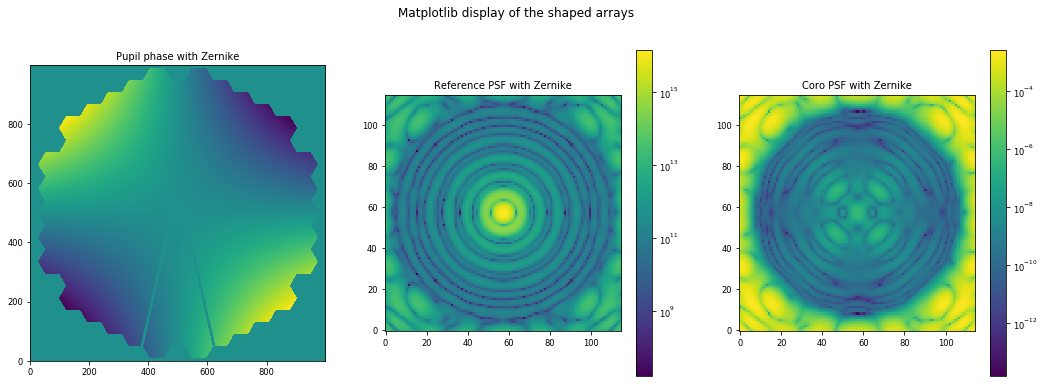

In [28]:
# Display them next to each other - as shaped arrays this time
plt.figure(figsize=(18, 6))
plt.suptitle('Matplotlib display of the shaped arrays')

plt.subplot(1, 3, 1)
plt.imshow(inter_zern['seg_mirror'].shaped)
plt.title('Pupil phase with Zernike')

plt.subplot(1, 3, 2)
plt.imshow(ref_zern.shaped, norm=LogNorm())
plt.title('Reference PSF with Zernike')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(coro_zern.shaped/norm, norm=LogNorm())
plt.title('Coro PSF with Zernike')
plt.colorbar() 

### Combining errors

In the general case, we will want to be able to apply several Zernikes at once to the pupil phase. This is simply done by adding up all needed Zerenikes into one "master Zernike".

In [29]:
# Combine defocus and astigmatism from above
master_zern = 0.8 * defocus_mode + 0.3 * zernike_mode

# Then apply this master Zernike to telescope pupil
luvoir.apply_global_zernike(master_zern)

# Calculate the PSFs and intermediate planes
coro_master, ref_master, inter_master = luvoir.calc_psf(ref=True, return_intermediate='intensity')

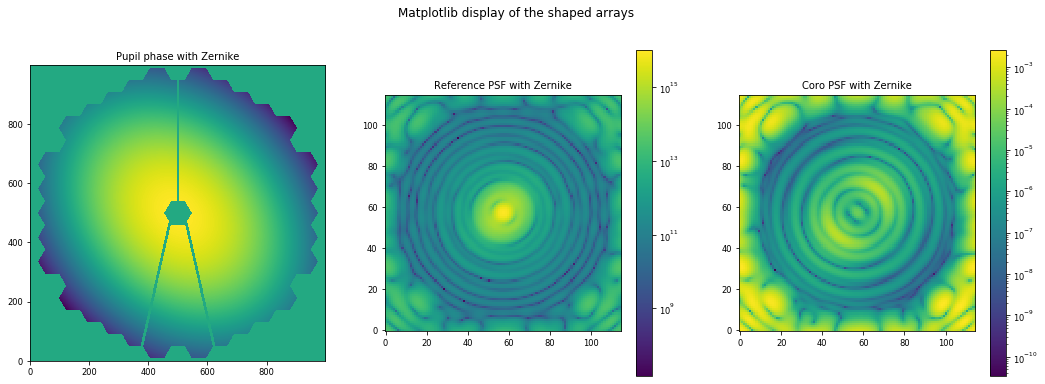

In [30]:
# Display them next to each other - as shaped arrays this time
plt.figure(figsize=(18, 6))
plt.suptitle('Matplotlib display of the shaped arrays')

plt.subplot(1, 3, 1)
plt.imshow(inter_master['seg_mirror'].shaped)
plt.title('Pupil phase with Zernike')

plt.subplot(1, 3, 2)
plt.imshow(ref_master.shaped, norm=LogNorm())
plt.title('Reference PSF with Zernike')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(coro_master.shaped/norm, norm=LogNorm())
plt.title('Coro PSF with Zernike')
plt.colorbar() 

In [31]:
# zerns upto 9, normalization = rms, units = radians, lam 638 nm, amplitude: +/- 0.5

# Deep-learning

In [5]:
# Architechture, back bone of network

def get_model1(Xshape, Yshape,**kwargs):

    lr = kwargs.get('lr', 1e-4) # learning rate - how fast to change the parameters
    loss = kwargs.get('loss', 'mean_squared_error')  # what kind of error should be calculated
    kernel_size = kwargs.get('kernel_size', (3,3))
    activation = kwargs.get('activation', 'relu')  # a regularizer
    padding = kwargs.get('padding', 'same')


    inp = Input(name='X', shape=Xshape)
    t = Conv2D(8, name='conv1', kernel_size=kernel_size, activation=activation, padding=padding)(inp)
    # convolutional layer
    # first number is number of kernels - here 8
    t = Conv2D(8, name='conv2', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = MaxPool2D(name='maxpool1', pool_size=(2, 2))(t)
    t = Conv2D(16, name='conv3', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = Conv2D(16, name='conv4', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = MaxPool2D(name='maxpool2', pool_size=(2, 2))(t)
    t = Conv2D(32, name='conv5', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = Conv2D(32, name='conv6', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = MaxPool2D(name='maxpool3', pool_size=(2, 2))(t)
    t = Conv2D(64, name='conv7', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = Conv2D(64, name='conv8', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = MaxPool2D(name='maxpool4', pool_size=(2, 2))(t)
    t = Conv2D(128, name='conv9', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = Conv2D(128, name='conv10', kernel_size=kernel_size, activation=activation, padding=padding)(t)
    t = MaxPool2D(name='maxpool5', pool_size=(2, 2))(t)
    t = Flatten(name='flat')(t)
    t = Dense(64, name='dense1', activation=activation)(t)
    t = Dense(64, name='dense2', activation=activation)(t)
    oup = Dense(Yshape, name='Y', activation='linear')(t)

    model = Model(inputs=inp, outputs=oup)
    model.compile(loss=loss, optimizer=Adam(lr))
    return model

In [7]:

noll_index = 5
n_def, m_def = hc.mode_basis.noll_to_zernike(noll_index)
zernike_mode = hc.mode_basis.zernike(n_def, m_def, D=luvoir.diam, grid=luvoir.aperture.grid)

def getdata(num=100):
    X = list()
    Y = list()
    for i in range(num):

        a_zern = np.random.uniform(-0.2,0.2) #0.23   # rad
        luvoir.apply_global_zernike(a_zern * zernike_mode)
        coro_zern, ref_zern, inter_zern = luvoir.calc_psf(ref=True, return_intermediate='intensity')

        # Cast into normal numpy array
        coro_zern = coro_zern.shaped

        coro_zern = normalize(coro_zern)
        X.append(coro_zern)
        Y.append(a_zern)
    
    return np.array(X), np.array(Y)

Xt, Yt = getdata(num=2)
Xv, Yv = getdata(num=1)

In [10]:
Yt = np.reshape(a=Yt, newshape=(2,1))
Yv = np.reshape(a=Yv, newshape=(1, 1))

In [11]:
Xt.shape, Yt.shape

((2, 115, 115), (2, 1))

In [12]:
Xv.shape, Yv.shape

((1, 115, 115), (1, 1))

In [13]:
Xv = np.expand_dims(Xv, axis = -1)
Xt = np.expand_dims(Xt, axis = -1)

In [14]:
model = get_model1(Xshape=Xv.shape[1:], Yshape=Yv.shape[1])
print(model.summary())

W0823 19:04:15.977726 140736552182720 deprecation_wrapper.py:119] From /Users/ilaginja/anaconda/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 19:04:16.015781 140736552182720 deprecation_wrapper.py:119] From /Users/ilaginja/anaconda/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 19:04:16.059124 140736552182720 deprecation_wrapper.py:119] From /Users/ilaginja/anaconda/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0823 19:04:16.194108 140736552182720 deprecation_wrapper.py:119] From /Users/ilaginja/anaconda/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 115, 115, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 115, 115, 8)       80        
_________________________________________________________________
conv2 (Conv2D)               (None, 115, 115, 8)       584       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 57, 57, 8)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 57, 57, 16)        1168      
_________________________________________________________________
conv4 (Conv2D)               (None, 57, 57, 16)        2320      
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 28, 28, 16)        0         
__________

In [ ]:
model.fit(x=Xt,y=Yt,epochs=10,validation_data=(Xv,Yv),batch_size=5)

W0823 19:04:18.669509 140736552182720 deprecation_wrapper.py:119] From /Users/ilaginja/anaconda/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0823 19:04:19.001367 140736552182720 deprecation_wrapper.py:119] From /Users/ilaginja/anaconda/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 2 samples, validate on 1 samples
Epoch 1/10


In [ ]:
Xtesting,  Ytesting = getdata(num=10)

In [ ]:
Xtesting = np.expand_dims(Xtesting,axis=-1)

In [ ]:
prediction = model.predict(Xtesting)

In [ ]:
prediction.shape

In [ ]:
plt.plot(prediction,'o', label='Prediction', fillstyle='top', markersize=5)
plt.plot(Ytesting, '*',label='ground truth')
plt.legend()
plt.ylabel("Astigm coeff in rad")
plt.xlabel("Coro PSF Num")

In [ ]:
plt.imshow(Xtesting[0,:,:,0])
plt.colorbar()